# A comprehensive study of DPNets on the logistic map

In [1]:
%load_ext autoreload

In [2]:
#Configs
import ml_confs as mlcfg
configs = mlcfg.from_file('configs.yaml', register_jax_pytree=False)

In [3]:
%autoreload 2
from functools import partial
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
import scipy.linalg
import scipy.stats
from scipy.integrate import romb
from rich.console import Console
from rich.table import Table
#Set plotting styles
import scienceplots
plt.style.use(['nature', 'retro'])
plt.rcParams['figure.dpi'] = 120
plt.rcParams['font.size'] = 10
plt.rcParams['axes.labelsize'] = 10
plt.rcParams['xtick.labelsize'] = 9
plt.rcParams['ytick.labelsize'] = 9

#Torch imports
import lightning
import torch
from torch.utils.data import DataLoader
from lightning.pytorch.callbacks import LearningRateFinder

#Kooplearn imports
from kooplearn.abc import FeatureMap
from kooplearn.models.feature_maps import ConcatenateFeatureMaps
from kooplearn.datasets import LogisticMap
from kooplearn._src.metrics import directed_hausdorff_distance
from kooplearn.nn.data import TrajToContextsDataset

# Noisy Logistic map
We initialize the `kooplearn.dataset` corresponding to the noisy logistic map and plot the true singular values and eigenvalues, showing the non-normality of the dynamical system

In [4]:
logistic = LogisticMap(N = configs.N)

In [5]:
sample_traj = logistic.sample(0.5, configs.num_train+configs.num_val+configs.num_test)
dataset = {
    'train': sample_traj[:configs.num_train],
    'validation': sample_traj[configs.num_train:configs.num_train+configs.num_val],
    'test': sample_traj[configs.num_train+configs.num_val:]
}

Text(0.5, 0, '$x$')

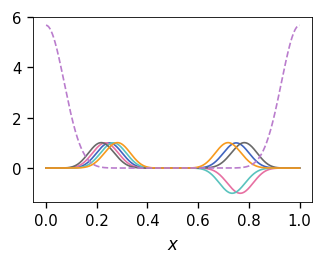

In [34]:
import scipy.special
N = 20
C = np.pi / scipy.special.beta(N // 2 + 0.5, 0.5)

binom_coeffs = [scipy.special.binom(N, i) for i in range(N + 1)]
sorted_coeffs = np.flip(np.argsort(binom_coeffs))
# Plotting noise features
x = np.linspace(0, 1, 1001)
fig, ax = plt.subplots(1, 1, figsize=(3, 2))
for i in range(5):
    ax.plot(x, logistic.noise_feature(x, sorted_coeffs[i]), label=f'$\phi_{i}$')
ax.plot(x, C*np.cos(np.pi*x)**N, '--')
ax.set_xlabel('$x$')   

In [33]:
sorted_coeffs[::-1 ]

array([10, 11,  9, 12,  8,  7, 13,  6, 14,  5, 15, 16,  4,  3, 17, 18,  2,
        1, 19, 20,  0])

How bad is the approximation that the data are sampled from the invariant distribution?

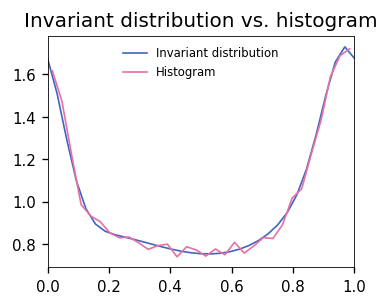

In [7]:
pow_of_two = 5
sample_distr = np.histogram(sample_traj, bins=2**pow_of_two, range=(0, 1), density=True)
vals, lv = logistic.eig(eval_left_on=np.linspace(0, 1, 2**pow_of_two + 1))
perron_eig_idx = np.argmax(np.abs(vals))
pi = lv[:, perron_eig_idx]
assert np.isreal(pi).all()
pi = pi.real
pi = pi/romb(pi, dx = 1/2**pow_of_two)
plt.plot(sample_distr[1], pi, label='Invariant distribution')
dx = 1/2**(pow_of_two + 1)
plt.plot(sample_distr[1][: -1] + dx, sample_distr[0], label='Histogram')
plt.title('Invariant distribution vs. histogram')
plt.margins(x=0)
plt.legend(frameon=False)

The logistic map is a non-normal dynamical system. This can be visualized by comparing the eigenvalues against the singular values of the transfer operator:

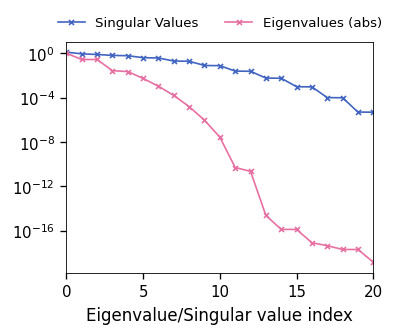

In [8]:
plt.plot(logistic.svals(), 'x-', label= 'Singular Values')
plt.plot(np.abs(logistic.eig()), 'x-', label = 'Eigenvalues (abs)')
plt.margins(x=0)
plt.yscale('log')
plt.xlabel("Eigenvalue/Singular value index")
plt.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1., 1, 0), ncol=2, fontsize=8)

# Setting up an evaluation scheme.

## Population estimators
As we are able to compute everything for this system, we evaluate the performance of `DPNets` in two stages. In the first stage we take three different feature maps:
1. Chebyshev polynomials up to order $\ell$
2. `VAMPNets` with latent dimension $\ell$ (MLP architecture tbd)
3. `DPNets` with latend dimension $\ell$ (MLP architecture tbd)

Given $\phi \colon [0, 1]\to \mathbb{R}^{\ell}$, we evaluate $C_{ij} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(x) \pi(dx)$, where $\pi$ is the invariant distribution. And the cross covariance $C_{ij}^{\times} := \int_{0}^{1} \phi_{i}(x)\phi_{j}(y) \pi(dx)p(x, dy) = \sum_{n = 0}^{N}\left(\int_{0}^{1} \phi_{i}(x)\alpha_{n}(x)\pi(dx)\right)\left(\int_{0}^{1} \phi_{j}(y)\beta_{n}(y)dy\right)$. As the kernel is separable, I just need to compute $2(N + 1)$ single integrals. 

Now, the OLS Transfer operator estimator is $G_{{\rm OLS}} = C^{\dagger}C^{\times}$, from which I can compute:
1. Directed Hausdorff spectral distance
2. Approximation error $\Vert [I - P_{\mathcal{H}}]\mathcal{T}|_{\mathcal{H}}\Vert$, for which $\mathcal{P}$ and $\mathcal{S}$ are proxies.
3. VAMP-score $\mathcal{P}$ + something related to metric distortion. An example could be $\mathcal{P}/\kappa (C)$

## Empirical estimators
In the second stage we pull into the ring every Koopman estimator we have and we compute, from data:

- Directed Hausdorff distance as a metric for the spectral estimation.
- MAE on 1-step ahead conditional expectation. Even if the system is stochastic, since it is of the form $X_{t + 1} = F(X_t) + \xi_{t}$ where $\xi_{t}$ is zero-mean, the expected value conditioned on $X_t = x$ is just $F(x)$.

# Population validators

In [52]:
def population_covs(feature_map: FeatureMap, pow_of_two_k: int = 12):
    """Computes the population covariance and cross-covariance"""
    x = np.linspace(0, 1, 2**pow_of_two_k + 1)[:, None]
    vals, lv = logistic.eig(eval_left_on=x)
    perron_eig_idx = np.argmax(np.abs(vals))
    pi = lv[:, perron_eig_idx]
    assert np.isreal(pi).all()
    pi = pi.real
    pi = pi/romb(pi, dx = 1/2**pow_of_two_k) #Normalization of π
    #Evaluating the feature map
    phi = feature_map(x) # [2**pow_of_two_k + 1, d]
    #Covariance
    cov_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*phi.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    cov = romb(cov_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    #Cross-covariance
    alphas = np.stack([logistic.noise_feature_composed_map(x, n) for n in range(logistic.N + 1)], axis = 1)
    betas = np.stack([logistic.noise_feature(x, n) for n in range(logistic.N + 1)], axis = 1)

    cov_alpha_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*alphas.reshape(2**pow_of_two_k + 1, 1, -1)*pi.reshape(-1, 1, 1)
    cov_beta_unfolded = phi.reshape(2**pow_of_two_k + 1, -1, 1)*betas.reshape(2**pow_of_two_k + 1, 1, -1)

    cov_alpha = romb(cov_alpha_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    cov_beta = romb(cov_beta_unfolded, dx = 1/2**pow_of_two_k, axis=0)
    
    cross_cov = cov_alpha@(cov_beta.T)
    return cov, cross_cov

def evaluate_representation(feature_map: FeatureMap):
    report = {}
    #Compute OLS estimator
    cov, cross_cov = population_covs(feature_map)
    OLS_estimator = np.linalg.solve(cov, cross_cov)
    #Eigenvalue estimation
    OLS_eigs = np.linalg.eigvals(OLS_estimator)
    report['hausdorff-dist'] = directed_hausdorff_distance(OLS_eigs, logistic.eig())
    #VAMP2-score
    M = np.linalg.multi_dot([np.linalg.pinv(cov, hermitian=True), cross_cov, np.linalg.pinv(cov, hermitian=True), cross_cov.T])
    feature_dim = cov.shape[0]
    report['SVD-error'] = np.sum(logistic.svals()[:feature_dim]**2) - np.trace(M)
    #Metric distortion
    cov_eigs = np.linalg.eigvalsh(cov)
    report['fro-Id-cov'] = np.max(np.abs(cov_eigs - np.ones_like(cov_eigs)))
    report['feature-map'] = feature_map
    return report

def tabulate_reports(reports):
    console = Console()
    table = Table(show_header=True, header_style="bold")
    table.add_column("Representation", justify='right')
    table.add_column("Hausdorff dist",justify='center')
    table.add_column("SVD Error",justify='center')
    table.add_column("||Id - cov||",justify='center')
    for model_name, model_report in reports.items():
        hausdorff = f"{model_report['hausdorff-dist']:.3f}"
        SVD_err = f"{model_report['SVD-error']:.3f}"
        fro_dist = f"{model_report['fro-Id-cov']:.3f}"
        table.add_row(model_name, hausdorff, SVD_err, fro_dist)
    console.print(table)

def flatten_reports(reports):
    #Reports must all be of depth 1 and with the same shape. No checks are performed 
    flattened = {}
    for model_name, model_report in reports.items():
        for report_stub, value in model_report.items():
            if report_stub in flattened:
                flattened[report_stub].append(value)
            else:
                flattened[report_stub] = [value]
    return flattened

# Noise feature map

In [106]:
def NoiseKernel(order: int = 3):
    binom_coeffs = [scipy.special.binom(N, i) for i in range(N + 1)]
    sorted_coeffs = np.argsort(binom_coeffs)
    def noise_kernel_beta(n, x):
        return logistic.noise_feature(x, n)
    def noise_kernel_alpha(n, x):
        return logistic.noise_feature_composed_map(x, n)
    fn_list = [partial(noise_kernel_beta, n) for n in sorted_coeffs[:order]]
    fn_list += [partial(noise_kernel_alpha, n) for n in sorted_coeffs[:order]]
    return ConcatenateFeatureMaps(fn_list)

# Chebyshev polynomials of the first kind

In [113]:
def ChebyT(feature_dim: int = 3):
        def scaled_chebyt(n, x):
            return scipy.special.eval_chebyt(n, 2 * x - 1)

        fn_list = [partial(scaled_chebyt, n) for n in range(feature_dim)]
        return ConcatenateFeatureMaps(fn_list)

In [114]:
reports = {}
max_order = 21
min_order = 2
for i in range(min_order, max_order):
    model_name = f"ChebyT{i}"
    print(len(ChebyT(i).feature_maps))
    reports[model_name] = evaluate_representation(ChebyT(i))
flattened = flatten_reports(reports)
tabulate_reports(reports)

2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20


┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Representation ┃ Hausdorff dist ┃ SVD Error ┃ ||Id - cov|| ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│        ChebyT2 │     0.007      │   1.310   │    0.587     │
│        ChebyT3 │     0.235      │   1.533   │    0.624     │
│        ChebyT4 │     0.253      │   1.821   │    0.712     │
│        ChebyT5 │     0.196      │   1.395   │    0.732     │
│        ChebyT6 │     0.201      │   1.538   │    0.787     │
│        ChebyT7 │     0.202      │   1.240   │    0.798     │
│        ChebyT8 │     0.204      │   1.276   │    0.832     │
│        ChebyT9 │     0.095      │   0.935   │    0.838     │
│       ChebyT10 │     0.097      │   0.938   │    0.862     │
│       ChebyT11 │     0.090      │   0.638   │    0.866     │
│       ChebyT12 │     0.093      │   0.638   │    0.883     │
│       ChebyT13 │     0.061      │   0.441   │    0.886     │
│       ChebyT14 │     0.062      │   0.440   │    0.898     │
│       ChebyT15 │     0.058      │   0.295   │    0.900     │
│       ChebyT16 │     0.060      │   0.295   │    0.910     │
│       ChebyT17 │     0.036      │   0.193   │    0.912     │
│       ChebyT18 │     0.037      │   0.193   │    0.920     │
│       ChebyT19 │     0.033      │   0.128   │    0.921     │
│       ChebyT20 │     0.034      │   0.128   │    0.927     │
└────────────────┴────────────────┴───────────┴──────────────┘

In [109]:
reports = {}
for i in range(1 + min_order, max_order + 1):
    model_name = f"NoiseKernel{i}"
    reports[model_name] = evaluate_representation(NoiseKernel(i))
flattened_noisekernel = flatten_reports(reports)
tabulate_reports(reports)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Representation ┃ Hausdorff dist ┃ SVD Error ┃ ||Id - cov|| ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│   NoiseKernel3 │     0.158      │   1.909   │    0.928     │
│   NoiseKernel4 │     0.153      │   1.752   │    0.928     │
│   NoiseKernel5 │     0.151      │   1.541   │    1.027     │
│   NoiseKernel6 │     0.122      │   1.350   │    1.132     │
│   NoiseKernel7 │     0.205      │   1.033   │    1.132     │
│   NoiseKernel8 │     0.149      │   0.748   │    1.134     │
│   NoiseKernel9 │     0.067      │   0.481   │    1.179     │
│  NoiseKernel10 │     0.038      │   0.391   │    1.219     │
│  NoiseKernel11 │     0.018      │   0.210   │    1.221     │
│  NoiseKernel12 │     0.013      │   0.079   │    1.223     │
│  NoiseKernel13 │     0.002      │   0.077   │    1.244     │
│  NoiseKernel14 │     0.002      │   0.077   │    1.270     │
│  NoiseKernel15 │     0.001      │   0.035   │    1.272     │
│  NoiseKernel16 │     0.000      │   0.028   │    1.275     │
│  NoiseKernel17 │     0.000      │   0.028   │    1.292     │
│  NoiseKernel18 │     0.002      │   0.032   │    1.315     │
│  NoiseKernel19 │     0.002      │   0.019   │    1.317     │
│  NoiseKernel20 │     0.642      │   0.028   │    1.320     │
│  NoiseKernel21 │     0.201      │   0.029   │    1.345     │
└────────────────┴────────────────┴───────────┴──────────────┘

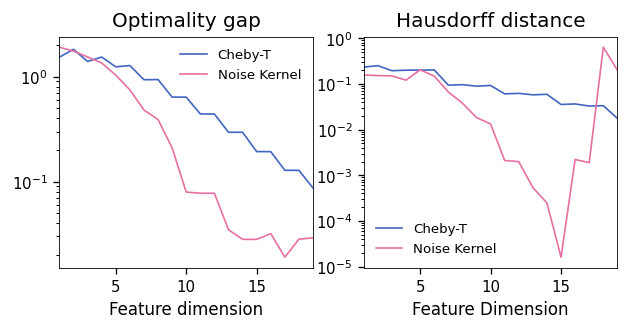

In [110]:
fig, axes = plt.subplots(1, 2, figsize=(6, 2.5))
#SVD error
ax = axes[0]
poly_order = len(flattened['SVD-error'])
ax.plot(np.arange(1, poly_order + 1), flattened['SVD-error'], label = "Cheby-T")
ax.plot(np.arange(1, poly_order + 1), flattened_noisekernel['SVD-error'], label = "Noise Kernel")
ax.set_title('Optimality gap')
ax.set_xlabel('Feature dimension')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, fontsize=8)

ax = axes[1]
#Hausdorff distance
ax.plot(np.arange(1, poly_order + 1), flattened['hausdorff-dist'], label ="Cheby-T")
ax.plot(np.arange(1, poly_order + 1), flattened_noisekernel['hausdorff-dist'], label ="Noise Kernel")
ax.set_title('Hausdorff distance')
ax.set_xlabel('Feature Dimension')
ax.set_yscale('log')
ax.set_xmargin(0)
ax.legend(frameon=False, fontsize=8)

### Defining a standard MLP architecture

In [91]:
class SinusoidalEmbedding(torch.nn.Module):
    def __init__(self):
        super().__init__()
    def forward(self, x):
        #Assuming x is in [0, 1]
        x = 2*torch.pi*x
        return torch.cat([torch.sin(x), torch.cos(x)], dim=-1)

class SimpleMLP(torch.nn.Module):
    def __init__(self, feature_dim: int, layer_dims: list[int], activation = torch.nn.LeakyReLU):
        super().__init__()
        self.activation = activation
        lin_dims = [2] + layer_dims + [feature_dim] #The 2 is for the sinusoidal embedding
        
        layers = []
        for layer_idx in range(len(lin_dims) - 2):
            layers.append(torch.nn.Linear(lin_dims[layer_idx], lin_dims[layer_idx+1], bias=False))
            layers.append(activation())
        layers.append(torch.nn.Linear(lin_dims[-2], lin_dims[-1], bias=True))
        self.layers = torch.nn.ModuleList(layers)
        self.sin_embedding = SinusoidalEmbedding()
    
    def forward(self, x):
        #Sinusoidal embedding
        x = self.sin_embedding(x)
        #MLP
        for layer in self.layers:
            x = layer(x)
        return x
    
def kaiming_init(model):
    for p in model.parameters():
        psh = p.shape
        if len(psh) == 2: #Linear layers
            _, in_shape = psh
            if in_shape == 2: #Initial layer
                torch.nn.init.uniform_(p, -1, 1)
            else:
                acname = model.activation.__name__.lower()
                if acname == 'leakyrelu':
                    acname = 'leaky_relu'
                torch.nn.init.kaiming_uniform_(p, a= 1, nonlinearity=acname)
        else: #Bias
            torch.nn.init.zeros_(p)

### Data and config init for DL methods

In [13]:
#Preparing the data
train_data = torch.from_numpy(dataset['train']).float()
val_data = torch.from_numpy(dataset['validation']).float()

train_ds = TrajToContextsDataset(train_data)
val_ds = TrajToContextsDataset(val_data)

train_dl = DataLoader(train_ds, batch_size=configs.batch_size, shuffle=True)
val_dl = DataLoader(val_ds, batch_size=len(val_ds), shuffle=False)

#Init report dict
dl_reports = {}

min_lr = 1e-4
max_lr = 1e-2

opt = torch.optim.Adam
opt_args = {'lr': 5e-5}

trainer_kwargs = {
    'accelerator': 'cpu',
    'devices': 1,
    'max_epochs': 500,  
    'log_every_n_steps': configs.log_every,
    #'callbacks': [lr_finder],
}
net_kwargs = {
    'feature_dim': configs.feature_dim,
    'layer_dims': configs.layer_dims
}

## VAMPNets

In [14]:
%autoreload 2
from kooplearn.models.feature_maps import VAMPNet
#Init trainer and LR finder
lr_finder = LearningRateFinder(min_lr=min_lr, max_lr=max_lr, early_stop_threshold=None)
trainer = lightning.Trainer(**trainer_kwargs, callbacks=[lr_finder])
#Defining the model
vamp_fmap = VAMPNet(
    SimpleMLP,
    opt,
    opt_args,
    trainer,
    net_kwargs,
    lobe_timelagged=SimpleMLP,
    lobe_timelagged_kwargs=net_kwargs,
    center_covariances=False,
    seed=configs.rng_seed
)
#Init
torch.manual_seed(configs.rng_seed)
kaiming_init(vamp_fmap.lightning_module.lobe)
kaiming_init(vamp_fmap.lightning_module.lobe_timelagged)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
Global seed set to 0


In [31]:
vamp_fmap.fit(train_dl)
dl_reports['VAMPNet'] = evaluate_representation(vamp_fmap)

## DPNets

In [16]:
%autoreload 2
from kooplearn.models.feature_maps import DPNet
lr_finder = LearningRateFinder(min_lr=min_lr, max_lr=max_lr, early_stop_threshold=None)
trainer = lightning.Trainer(**trainer_kwargs, callbacks=[lr_finder])

#Defining the model
dpnet_fmap = DPNet(
    SimpleMLP,
    opt,
    opt_args,
    trainer,
    use_relaxed_loss=False,
    metric_deformation_loss_coefficient=1.0,
    encoder_kwargs=net_kwargs,
    encoder_timelagged=SimpleMLP,
    encoder_timelagged_kwargs=net_kwargs,
    center_covariances=False,
    seed=configs.rng_seed
)

#Init
torch.manual_seed(configs.rng_seed)
kaiming_init(dpnet_fmap.lightning_module.encoder)
kaiming_init(dpnet_fmap.lightning_module.encoder_timelagged)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/novelli/anaconda3/envs/kooplearn/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:176: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=2)`.
  rank_zero_warn(
Global seed set to 0


In [30]:
#dpnet_fmap.fit(train_dl)
dl_reports['DPNet'] = evaluate_representation(dpnet_fmap)

In [18]:
%autoreload 2
from kooplearn.models.feature_maps import DPNet
lr_finder = LearningRateFinder(min_lr=min_lr, max_lr=max_lr, early_stop_threshold=None)
trainer = lightning.Trainer(**trainer_kwargs)

#Defining the model
dpnet_relaxed_fmap = DPNet(
    SimpleMLP,
    opt,
    opt_args,
    trainer,
    use_relaxed_loss=True,
    metric_deformation_loss_coefficient=1.0,
    encoder_kwargs=net_kwargs,
    encoder_timelagged=SimpleMLP,
    encoder_timelagged_kwargs=net_kwargs,
    center_covariances=False,
    seed=configs.rng_seed
)

#Init
torch.manual_seed(configs.rng_seed)
kaiming_init(dpnet_relaxed_fmap.lightning_module.encoder)
kaiming_init(dpnet_relaxed_fmap.lightning_module.encoder_timelagged)

GPU available: True (cuda), used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
Global seed set to 0


In [29]:
#dpnet_relaxed_fmap.fit(train_dl)
dl_reports['DPNet-relaxed'] = evaluate_representation(dpnet_relaxed_fmap)

In [32]:
model_name = f"ChebyT-{configs.feature_dim - 1}"
dl_reports[model_name] = evaluate_representation(ChebyT(configs.feature_dim - 1))

In [33]:
tabulate_reports(dl_reports)

┏━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━┓
┃ Representation ┃ Hausdorff dist ┃ SVD Error ┃ ||Id - cov|| ┃
┡━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━┩
│        VAMPNet │     0.295      │   0.838   │    1.000     │
│          DPNet │     0.121      │   0.465   │    0.995     │
│  DPNet-relaxed │     0.061      │   1.098   │    0.981     │
│       ChebyT-7 │     0.204      │   1.276   │    0.832     │
└────────────────┴────────────────┴───────────┴──────────────┘

In [22]:
def plot_eigs(reports):
    fig, ax = plt.subplots(figsize=(5, 5))  
    #Activate grid
    ax.grid(True, which='both')
    #Plot unit circle
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(np.cos(theta), np.sin(theta), color='k', lw=0.75)   
    for model_name, model_report in reports.items():
        cov, cross_cov = population_covs(model_report['feature-map'])
        OLS_estimator = np.linalg.solve(cov, cross_cov)
        OLS_eigs = np.linalg.eigvals(OLS_estimator)
        print(f"{model_name} eigenvalues: {OLS_eigs}")
        ax.scatter(OLS_eigs.real, OLS_eigs.imag, label = model_name)
    ax.scatter(logistic.eig().real, logistic.eig().imag, marker='x', color='k', label = 'True eigenvalues')
    ax.set_xlabel('Real part')
    ax.set_ylabel('Imaginary part')
    ax.legend(frameon=False, loc='lower center', bbox_to_anchor=(0, 1, 1, 0), ncol=3, fontsize=8)
    ax.set_aspect('equal')

VAMPNet eigenvalues: [ 0.99952008+0.j         -0.06556164+0.29054662j -0.06556164-0.29054662j
  0.15468443+0.j          0.0314618 +0.j         -0.00307385+0.j
 -0.01882419+0.j         -0.4180411 +0.j        ]
DPNet eigenvalues: [ 0.99935739+0.j         -0.20655514+0.1533964j  -0.20655514-0.1533964j
  0.02078657+0.1205812j   0.02078657-0.1205812j  -0.02649734+0.04024111j
 -0.02649734-0.04024111j  0.03348644+0.j        ]
DPNet-relaxed eigenvalues: [ 0.99914258+0.j         -0.19354123+0.18198268j -0.19354123-0.18198268j
  0.04319662+0.05681188j  0.04319662-0.05681188j -0.04435073+0.04023103j
 -0.04435073-0.04023103j -0.00253908+0.j        ]
ChebyT-7 eigenvalues: [ 1.00000000e+00+0.j         -2.65200568e-01+0.j
 -1.99171703e-02+0.17413995j -1.99171703e-02-0.17413995j
 -6.60902182e-02+0.j         -1.30302004e-02+0.j
  8.06205180e-06+0.j          1.78597901e-02+0.j        ]


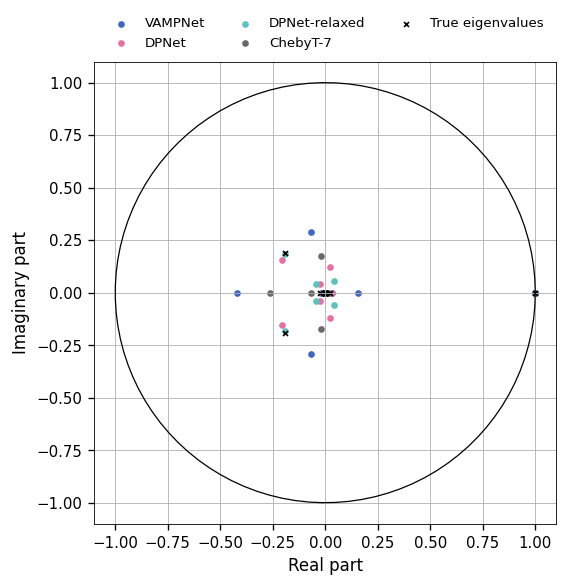

In [23]:
plot_eigs(dl_reports);

Check validation P score 

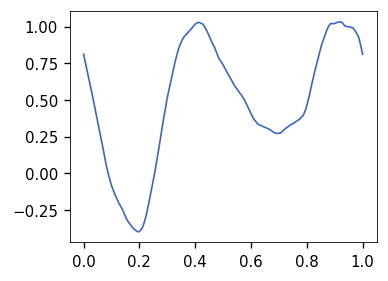

In [39]:
x = np.linspace(0, 1, 2**12 + 1)[:, None]
features = dpnet_fmap(x)
plt.plot(x, features[:, 2])